In [43]:
import numpy as np
# from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
from pprint import pprint
import scipy.ndimage
from IPython.display import display, Audio
from estimator import ActivationLearner
import scipy.signal
import logging
import beat_track
from unmixdb import UnmixDB
plt.style.use("dark_background")
logging.basicConfig(level=logging.INFO)
logging.getLogger("activation_learner").setLevel(logging.DEBUG)
from pathlib import Path


In [67]:
# Load audios

FS = 22050
# input_paths = ["linear-mix-1.wav", "linear-mix-2.wav", "linear-mix.wav"]
input_paths = ["linear-mix.wav"]
# input_paths = ["original.wav", "original.wav"]
# input_paths = ["original.wav", "boucled.wav"]
# input_paths = ["amen.wav", "high.wav", "nuttah.wav"]
# input_paths = ["nuttah.wav", "nuttah-timestretch.wav"]
inputs = [librosa.load(i, sr=FS)[0] for i in input_paths]


## load unmixdb
# unmixdb = UnmixDB("/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo")
# print(unmixdb.timestretches)
# print(unmixdb.fxes)
# mixes = dict(filter(lambda i: i[1].timestretch == "stretch" and i[1].fx=="none", unmixdb.mixes.items()))
# mix = list(mixes.values())[5]
# pprint(mix)
# inputs = [unmixdb.refsongs[track['name']].audio(sr=FS) for track in mix.tracks]
# inputs.append(mix.audio(sr=FS))

for i, x in enumerate(inputs):
    print(i)
    display(Audio(x, rate=FS))

0


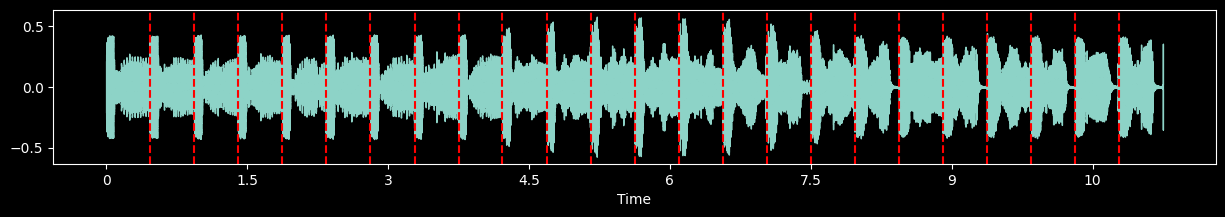

In [68]:
boundaries = []
for i in range(len(inputs)):
    xml_path = Path(input_paths[i]).with_suffix(".xml")
    with open(xml_path, 'rb') as f:
        beat_times = beat_track.parse_ircambeat_xml(f.read())
    beat_frames = (beat_times * FS).astype(int)
    bounds = np.array(list(zip(beat_frames[:-1], beat_frames[1:])))
    boundaries.append(bounds)
    plt.figure(figsize=(15,2))
    librosa.display.waveshow(inputs[i])
    for beat_time in beat_times:
        plt.axvline(x=beat_time, color='r', linestyle='--')
    plt.show()
    
    

loss=1.67e-01: 100%|██████████| 150/150 [00:01<00:00, 88.48it/s]


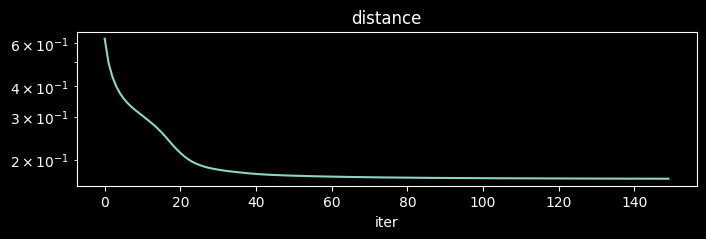

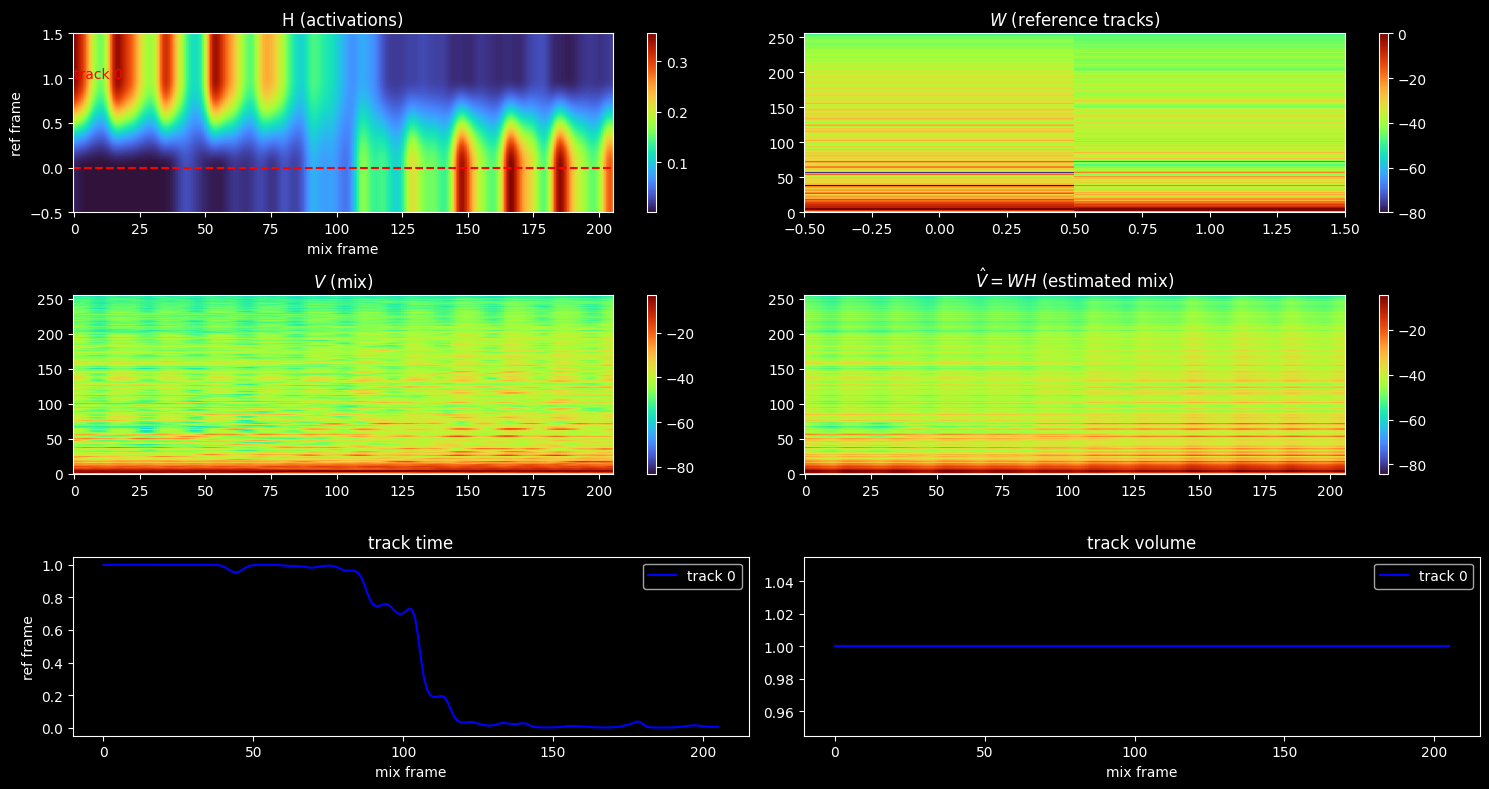

In [80]:
# model = ActivationLearner(
#     inputs,
#     fs=FS,
#     additional_dim=0,
#     win_len = 2**14,
#     hop_len = 2**12,
#     n_mels = 512,
#     stft_win_func=np.hanning
# )

model = ActivationLearner(
    inputs,
    fs=FS,
    additional_dim=2,
    n_mels = 256,
    # boundaries=boundaries,
    win_len = int(1 * FS),
    hop_len = int(0.05 * FS),
    stft_win_func=np.hanning,
    # spec_conv_win=scipy.signal.get_window("triang",3, False)
)

losses = []
for i in (pbar := tqdm(range(150))):
    loss = model.iterate()
    losses.append(loss)
    pbar.set_description(f"loss={loss:.2e}")
plt.figure(figsize=(8, 2))
plt.plot(losses)
plt.xlabel("iter")
plt.title("distance")
plt.yscale("log")
plt.show()
model.plot()

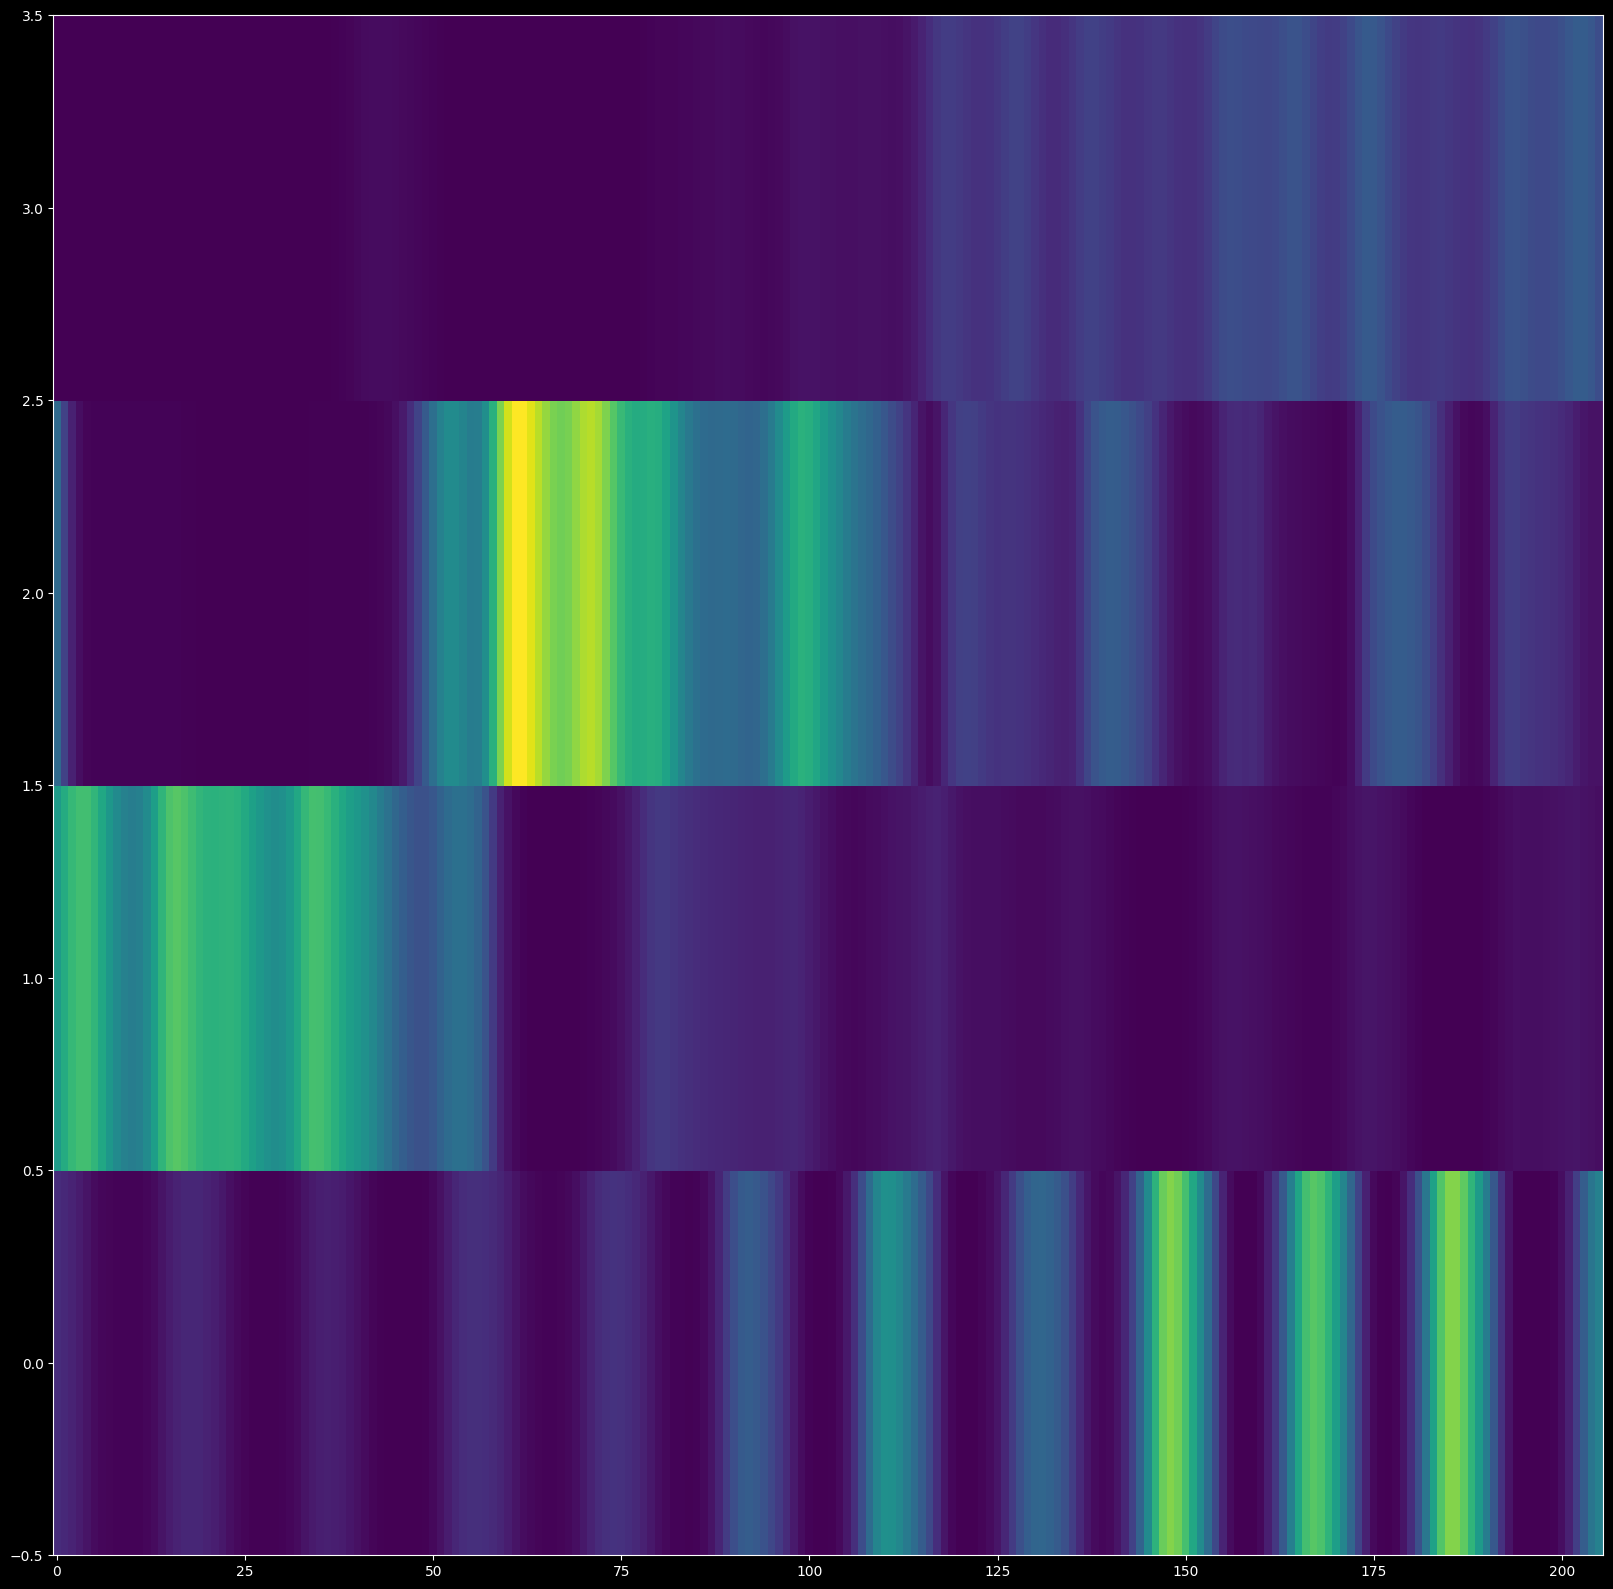

In [79]:
H = model.nmf.H.copy()
H.sort(axis=0)

plt.figure(figsize=(20,20))
plt.imshow(model.nmf.H, aspect="auto", origin="lower")

import soundfile as sf


def estimate_tracks():
    ret = []
    for i in range(len(refs) + 1):
        xi = model.reconstruct(i)
        ret.append(xi)
        print("track", i)
        display(Audio(xi, rate=FS))
        sf.write(f"estimated-{i}.wav", xi / xi.max(), FS)
    return ret